<a href="https://colab.research.google.com/github/nikhilkumar293/Machine_Learning/blob/main/Backpropagation_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
class Tensor:

    def __init__(self, data, requires_grad=False):
        self.data = data
        if not isinstance(data, np.ndarray):
            self.data = np.array(data)
        # whether to run backpropagation or not
        self.requires_grad = requires_grad
        # tensor gradient
        self._grad = None
        # operation if this tensor was used in it
        self._grad_fn = None

    @property
    def shape(self):
        return self.data.shape

    @property
    def grad_fn(self):
        if not self.requires_grad:
            raise Exception('This tensor is not backpropagated')
        return self._grad_fn

    @property
    def grad(self):
        return self._grad

    def backward(self, grad=None):
        if not self.grad_fn:
            return False

        if grad is None and self._grad is None:
            # in case if this is last loss tensor
            grad = self.__class__(1., requires_grad=False)

        elif self.grad is not None:
            grad = self._grad

        if not self.requires_grad:
            raise Exception('This tensor is not backpropagated')

        self.grad_fn.backward(grad)
        return True

    def __str__(self):
        return f'Tensor({str(self.data)})'

    def add_grad(self, grad):
        if self._grad is None:
            self._grad = grad
        else:
            self._grad += grad

    def __add__(self, o): 
        if self.data is not None:
            self.data += o.data  
            return self
        self.data = o.data 
        return self

class Op:

    def forward(self):
        raise NotImplemented

    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        self.out = self.forward(*args)
        self.out._grad_fn = self
        return self.out


class AddOp(Op):

    '''Sumation operation with 2 tensors'''

    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        # created tensor should be backpropagated if at least one 
        # of the input is backpropagated
        requires_grad = x.requires_grad or y.requires_grad
        return Tensor(x.data + y.data, requires_grad=requires_grad)

    def backward(self, grad):
        if self.x.requires_grad:
            # as we have matrix operation one of the parameters can have partial shape
            # in such scenarion we need to sum gradient values by missed axis
            if self.x.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.x.shape) - np.array(grad.shape)))
                self.x.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
            else:
                self.x.add_grad(grad)
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_grad:
            if self.y.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.y.shape) - np.array(grad.shape)))
                self.y.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
            else:
                self.y.add_grad(grad)
            if self.y.grad_fn:
                self.y.backward()


class MulOp(Op):

    '''Multiplication operation with 2 tensors'''

    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        requires_grad = x.requires_grad or y.requires_grad
        return Tensor(x.data * y.data, requires_grad=requires_grad)

    def backward(self, grad):
        if self.x.requires_grad:
            self.x.add_grad(Tensor(grad.data * self.y.data, False))
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_grad:
            self.y.add_grad(Tensor(grad.data * self.x.data, False))
            if self.y.grad_fn:
                self.y.backward()

In [ ]:
x = np.random.random((3,3))
a = np.random.random((3,3))
b = np.random.random((3,))

loss = np.random.random((3,3))

_x = Tensor(x,requires_grad=True)
_a = Tensor(a,requires_grad=True)
_b = Tensor(b,requires_grad=True)

# here we use parameter _a 2 times in different operations.
# that means that gradient will be calculated twice for _a.
# and thus we need to sum two gradients to get result 
# gradient for _a
y = MulOp()(
        AddOp()(
            MulOp()(
                _x, _a
            ), _b
        ), _a
    )
print('y = ', y)
print()
print('y.grad_fn = ', y.grad_fn)
print()
y.backward(Tensor(loss))
print('_x.grad = ',_x.grad)
print()
print('_a.grad = ',_a.grad) 
print()
print('_b.grad = ',_b.grad) 
print()
print('y.grad = ',y.grad)

y =  Tensor([[0.14067561 0.37990074 0.04720564]
 [0.00647128 0.39777235 0.00865987]
 [0.28590429 0.17211987 0.05220727]])

y.grad_fn =  <__main__.MulOp object at 0x7fe1a7af4e10>

_x.grad =  Tensor([[5.59770362e-02 5.80475215e-03 6.01206513e-03]
 [2.25165061e-04 2.18147350e-01 5.36525484e-04]
 [3.12019455e-01 3.54774661e-03 8.45999944e-03]])

_a.grad =  Tensor([[0.17182289 0.06270139 0.10851861]
 [0.33020266 0.63615355 0.28400934]
 [0.38486905 0.05442753 0.15730927]])

_b.grad =  Tensor([[0.65536827 0.44622377 0.12144421]])

y.grad =  None


In [ ]:
_x = torch.tensor(x,requires_grad=True)
_a = torch.tensor(a,requires_grad=True)
_b = torch.tensor(b,requires_grad=True)
y = (_a*_x + _b) * _a
print('y = ', y)
print()
print('y.grad_fn = ', y.grad_fn)
print()
y.backward(torch.tensor(loss))
print('_x.grad = ',_x.grad)
print()
print('_a.grad = ',_a.grad) 
print()
print('_b.grad = ',_b.grad) 
print()
print('y.grad = ',y.grad)

y =  tensor([[0.1407, 0.3799, 0.0472],
        [0.0065, 0.3978, 0.0087],
        [0.2859, 0.1721, 0.0522]], dtype=torch.float64, grad_fn=<MulBackward0>)

y.grad_fn =  <MulBackward0 object at 0x7fe1a7af4dd0>

_x.grad =  tensor([[5.5977e-02, 5.8048e-03, 6.0121e-03],
        [2.2517e-04, 2.1815e-01, 5.3653e-04],
        [3.1202e-01, 3.5477e-03, 8.4600e-03]], dtype=torch.float64)

_a.grad =  tensor([[0.1718, 0.0627, 0.1085],
        [0.3302, 0.6362, 0.2840],
        [0.3849, 0.0544, 0.1573]], dtype=torch.float64)

_b.grad =  tensor([0.6554, 0.4462, 0.1214], dtype=torch.float64)

y.grad =  None


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:475.)
  return self._grad


In [ ]:
class Layer:

    def forward(self):
        raise NotImplemented
    
    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        return self.forward(*args)

class Sigmoid:

    def forward(self,x):
        self.x = x   
        return 1/(1+np.exp(-x))
      
    def backward(self, grad):
        grad_input = self.x*(1-self.x) * grad
        return grad_input

class Relu(Layer):

    def forward(self,x):
        self.x = x
        return np.maximum(np.zeros_like(x), x)
      
    def backward(self, grad):
        grad_input = (self.x > 0) * grad
        return grad_input

class SoftmaxCrossentropyWithLogits(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y

        exps = np.exp(x) 
        self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)

        logits = self.softmax[np.arange(x.shape[0]),y]
        log_likelihood = -np.log(logits)
        loss = np.sum(log_likelihood) / x.shape[0]
        return loss
      
    def backward(self, grad=None):
        batch = self.x.shape[0]
        grad = self.softmax
        grad[np.arange(batch),self.y] -= 1
        grad = grad/batch
        return grad

class MSE(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y
        return ((x - y)**2) / (self.x.shape[0]*2)

    def backward(self, grad=None):
        # 1/2n * Sum(xi-yi)**2 
        # dx = 1/2n * Sum( x**2 -2*x*y + y**2) 
        # dx  = (2x - 2y) / 2*n = (x - y) / n
        return (self.x - self.y) / self.x.shape[0]

class Linear(Layer):

    def __init__(self, input, output, lr=0.0001):
        self.A = 2*np.random.random((input, output)) - 1
        self.b = 2*np.random.random((output)) - 1
        self.lr = lr
    
    def forward(self, x):
        self.x = x
        return np.dot(x,self.A) + self.b

    def backward(self, grad):
        # d_layer / db = 1
        b_grad = grad.mean(axis=0)*self.x.shape[0]
        # d_layer / dA = x
        A_grad = np.dot(self.x.T, grad)
        # As this layer have somee weights we need to update them using 
        # gradient descent
        # compute df / dx = df / d_layer * d_layer / dx
        # df / d_layer == grad
        grad_input = np.dot(grad, self.A.T)
        
        self.A -= A_grad * self.lr
        self.b -= b_grad * self.lr

        return grad_input

In [ ]:
class Model(Layer):

    def __init__(self, lr=0.0001):
        self.lr = lr
        self.layers = [
            Linear(3,15, lr=self.lr),
            Relu(),
            Linear(15,1, lr=self.lr)        
        ]

    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)

        return grad

mm = Model()

def yf(x1,x2,x3):
    return np.array([2 * x1 + 3*x2 + 4*x3 + 5],dtype=np.float32)

loss = MSE()

for i in range(20000):
    x1 = np.random.random()*30
    x2 = np.random.random()*20
    x3 = np.random.random()*11
    y = mm(np.array([[x1,x2,x3]]))
    err = loss(y, yf(x1,x2,x3))
    
    yb = loss.backward()
    yb = mm.backward(yb)
    if i % 100 == 0:
        print(err)
        print('VAL Target:',yf(1,2,3), 'Res:',mm(np.array([[1,2,3]])), 'Loss:',loss(yf(1,2,3), mm(np.array([[1,2,3]]))))
        print('---------')

[[3496.41000899]]
VAL Target: [25.] Res: [[2.57162277]] Loss: [[251.51605252]]
---------
[[21.21054125]]
VAL Target: [25.] Res: [[17.80822879]] Loss: [[25.86078655]]
---------
[[1.23032574]]
VAL Target: [25.] Res: [[19.33162644]] Loss: [[16.06522942]]
---------
[[1.78062165]]
VAL Target: [25.] Res: [[20.24448975]] Loss: [[11.30743887]]
---------
[[3.56362303]]
VAL Target: [25.] Res: [[20.99152304]] Loss: [[8.03394378]]
---------
[[0.78077954]]
VAL Target: [25.] Res: [[21.0084955]] Loss: [[7.9660541]]
---------
[[0.03345762]]
VAL Target: [25.] Res: [[21.15979316]] Loss: [[7.37359429]]
---------
[[4.25343429]]
VAL Target: [25.] Res: [[20.94182405]] Loss: [[8.23439601]]
---------
[[0.73237673]]
VAL Target: [25.] Res: [[21.00453691]] Loss: [[7.98186264]]
---------
[[1.06057043]]
VAL Target: [25.] Res: [[21.35125683]] Loss: [[6.65666337]]
---------
[[0.05354533]]
VAL Target: [25.] Res: [[21.19778259]] Loss: [[7.22842861]]
---------
[[6.50167111e-06]]
VAL Target: [25.] Res: [[21.24105504]] L

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

class Model(Layer):

    def __init__(self, lr=0.00001):
        self.lr = lr
        self.layers = [
            Linear(784,100, lr=self.lr),
            Relu(),
            Linear(100,200, lr=self.lr),
            Relu(),
            Linear(200,10, lr=self.lr)        
        ]

    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)

        return grad


simple = transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
])
ds = MNIST('./mnist', download=True, transform=simple)
ld = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True) 

mm = Model()
loss = SoftmaxCrossentropyWithLogits()
_loss_avg = 0 
for e in range(7):
    for i, (img, label) in enumerate(ld):
        x = img.view(2,-1).numpy()

        res = mm(x)
        _loss = loss(res, label.numpy())
        _loss_avg += _loss.mean() # running loss mean
        grad = loss.backward(1)
        mm.backward(grad)

        if i % 100 == 0:
            print(_loss_avg/100)
            _loss_avg = 0
            print('---------')

1.1578908924992457
---------
147.6949820410577
---------
156.36192531760963
---------
134.93199053022985
---------
120.31746305980961
---------
128.49755284710616
---------
119.44392003690727
---------
113.1111876029765
---------
111.66448152443127
---------
99.64788047837251
---------
108.88298023998206
---------
111.88696681260647
---------
110.10759338100773
---------
100.48837348998686
---------
116.03927860083762
---------
97.29837923730825
---------
90.38854185445958
---------
80.93919445819498
---------
91.78300432472024
---------
99.6842242851917
---------
91.26123753598003
---------
87.332397796854
---------
81.53868233276938
---------
89.58547669668206
---------
82.83362919693316
---------
89.44441769861163
---------
82.90699235108406
---------
77.0705235925134
---------
84.96549935284561
---------
73.6337875141934
---------
64.49006592333555
---------
73.75776907824815
---------
80.876386999354
---------
65.12458844147346
---------
68.17478320316609
---------
73.735889161643

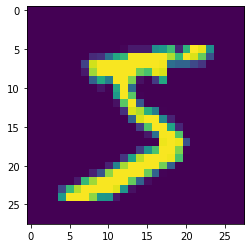

target: 5 predicted: 5


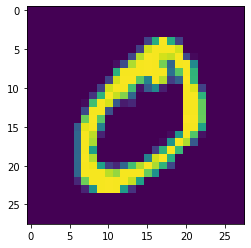

target: 0 predicted: 0


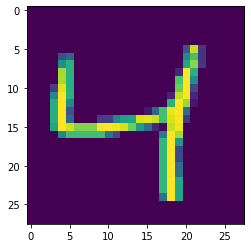

target: 4 predicted: 4


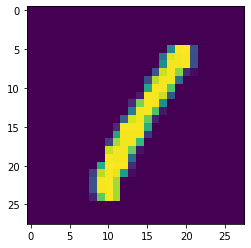

target: 1 predicted: 1


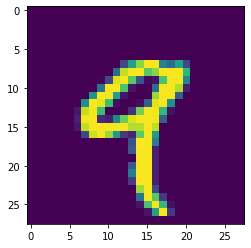

target: 9 predicted: 9


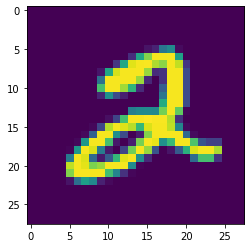

target: 2 predicted: 2


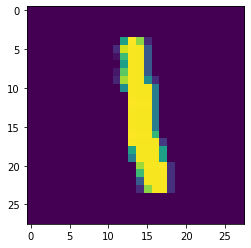

target: 1 predicted: 1


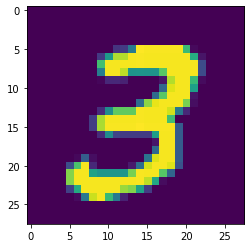

target: 3 predicted: 3


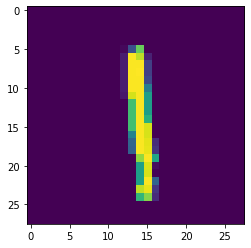

target: 1 predicted: 1


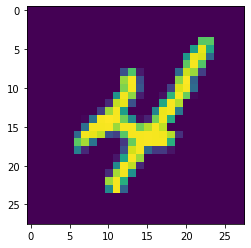

target: 4 predicted: 4


In [ ]:
for i in range(10):
    img, target = ds[i]
    plt.imshow(img[0])
    plt.show()
    x = img.view(1,-1).numpy()
    res = mm(x)[0]
    pred = np.argmax(res)
    print(f'target: {target} predicted: {pred}' )